<a href="https://colab.research.google.com/github/IvanWasNotAvailable/StockPricePrediction/blob/main/TwitterSentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Imports

In [3]:
# To get started, we need to ensure that the absolute latest version of Tweepy is 
# fully installed and overwrites any preexisting installations.

!pip install git+https://github.com/tweepy/tweepy.git --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tweepy/tweepy.git to /tmp/pip-req-build-aw0_hc96
  Running command git clone -q https://github.com/tweepy/tweepy.git /tmp/pip-req-build-aw0_hc96


In [4]:
# Import the tweepy package
import tweepy

# Import a variety of other packages that may be useful for working with data.
import pandas as pd
import json
import time

# 1. Authentification

In order for our code and commands to effectively communicate with the Twitter API, we need to "authenticate" our credentials with the services.

In [ ]:
# Before getting started with any code, we created an Twitter Developer account
# The various needed keys, secrets, and tokens are stored in variables 

#TO BE ABLE TO RUN THIS CODE WE PASTE OUR PRIVATE TWITTER API KEYS
my_consumer_key = "..."
my_consumer_secret = "..."

my_access_token = "..."
my_access_secret = "..."

my_bearer_token = "..."

In [5]:
# Using the tweepy.Client(...) function, you can establish a connection to the 
# Twitter API.  The example below shows a robust way of creating a "client" object
# by passing our credentials to appropriate parameters.

# Additionally, the "wait_on_rate_limit" parameter is set to True at this stage.
# This will be explained more later, but this helps to overcome a lot of errors
# associated with API usage limitations.

client = tweepy.Client(
    wait_on_rate_limit = True,
    consumer_key = my_consumer_key,
    consumer_secret = my_consumer_secret,
    access_token = my_access_token,
    access_token_secret = my_access_secret,
    bearer_token = my_bearer_token,
)

In [6]:
# Test to make sure the client object exists

client

In [7]:
# Do a quick test to make sure the client is working.  You should see a 
# "Response(..." object of some form displayed in the output if successful 
# (don't worry about the details, we will cover everything together)

client.get_user(username ="elonmusk")

Response(data=<User id=44196397 name=Elon Musk username=elonmusk>, includes={}, errors=[], meta={})

# 2.1 Getting Started - User Lookup

##2.1.1 Single User

In [7]:
#The following example uses our client object and the get_user(...) function to search for a specific 
# Twitter user's account by username.  The user_single object will be used to store the information returned to us.

# We'll starting by looking at the Twitter account for the new Twitter CEO, Elon Musk: https://twitter.com/elonmusk

user_single = client.get_user(
    username ="elonmusk",
)

In [8]:
user_single

Response(data=<User id=44196397 name=Elon Musk username=elonmusk>, includes={}, errors=[], meta={})

In [9]:
user_single.data

<User id=44196397 name=Elon Musk username=elonmusk>

In [10]:
user_single.data.name

'Elon Musk'

In [12]:
# Unintuitively, there is a "data" attribute within the "data" component 
# within the user_single object.  What's important is that this will give
# us ALL of the data delivered by the Twitter API.

# This information is structured as a dictionary and can be treated as a JSON 
# object when it is helpful.

user_single.data.data

{'id': '44196397', 'name': 'Elon Musk', 'username': 'elonmusk'}

In [17]:
# This information can also be accessed as key-value pairs using [...].

# These approaches to isolating individual data may be useful if you need 
# granular control individual datum values.

user_single.data.data["username"]

'elonmusk'

In [18]:
# Another more practical solution is to convert the data in a Pandas Dataframe

pd.json_normalize( user_single.data.data, sep="_" )

,id,name,username
0,44196397,Elon Musk,elonmusk


In [19]:
# "Fields" refer to the additional data you want to request from the Twitter 
# API.  There are very precise options available for "user fields", "tweet 
# fields", "media fields" and other "....fields" options.  Using these tools 
# robustly requires close reading of the documentation.

# Twitter API (get_user) - https://developer.twitter.com/en/docs/twitter-api/users/lookup/api-reference/get-users-by-username-username
# Twitter API (Fields) - https://developer.twitter.com/en/docs/twitter-api/fields
# Tweepy - https://docs.tweepy.org/en/latest/client.html#user-fields

# Based on information drawn from the documentation, the example below adds
# the user_fields=... parameter and a list[...] of desired fields.

user_single = client.get_user(
    username ="elonmusk",
    user_fields = ["created_at", "description","public_metrics","verified",],
)

In [20]:
# Convert data to Pandas DataFrame format.

pd.json_normalize( user_single.data.data, sep="_" )

,name,description,created_at,id,verified,username,public_metrics_followers_count,public_metrics_following_count,public_metrics_tweet_count,public_metrics_listed_count
0,Elon Musk,,2009-06-02T20:12:29.000Z,44196397,True,elonmusk,119837386,136,21021,104454


##2.1.2 User Group

In [21]:
users_group = client.get_users(
    usernames =["elonmusk","JeffBezos","richardbranson","BarackObama",],
    user_fields = ["created_at", "description","public_metrics","verified",],
)

In [26]:
#Each item can be accessed in the same way you index and select items from other lists.

users_group.data[1].data["username"]

'JeffBezos'

In [27]:
# Create empty dataframe
data_users = pd.DataFrame()

# Iterate through users_group and append data to the data_users dataframe
for i in users_group.data:
  temp_data = pd.json_normalize( i.data ,  sep = "_")
  data_users = data_users.append( temp_data , ignore_index=True )

In [28]:
# Inspect the dataframe

data_users

,id,name,description,created_at,verified,username,public_metrics_followers_count,public_metrics_following_count,public_metrics_tweet_count,public_metrics_listed_count
0,44196397,Elon Musk,,2009-06-02T20:12:29.000Z,True,elonmusk,119836662,136,21021,104457
1,15506669,Jeff Bezos,Amazon. Blue Origin. Washington Post. Bezos Ea...,2008-07-20T22:38:36.000Z,True,JeffBezos,5927999,113,381,11333
2,8161232,Richard Branson,"Tie-loathing adventurer, philanthropist & trou...",2007-08-13T15:20:18.000Z,True,richardbranson,12622741,977,26635,44344
3,813286,Barack Obama,"Dad, husband, President, citizen.",2007-03-05T22:08:25.000Z,True,BarackObama,133240688,568189,16711,218731


# 2.2 Getting Started - Followers

In addition to looking up individual users' information, the Twitter API also enables us to harvest lists of friends, followers, and the timeline (tweets, retweets, etc...) of selected Twitter users.

In [29]:
# Let's look at data from BASF: https://twitter.com/basf

basf = client.get_user(
    username = "BASF",
    user_fields = ["created_at", "description","public_metrics","verified",],
)

In [30]:
# In order to user subsequent functions, we need to switch from relying on the 
# Twitter username to instead using the Twitter id

basf.data.id

164641631

In [39]:
# Using the get_users_following(...) function, you can retrieve the Twitter user 
# account details for up to 1000 Twitter users who BASF's Twitter account is following.

basf_following = client.get_users_following(
    id = basf.data.id ,
    user_fields = ["created_at", "description","public_metrics","verified",],
    max_results = 10)

In [40]:
# Inspect the resulting list of data

basf_following.data

[<User id=260771406 name=KfW Bankengruppe username=KfW>,
 <User id=1463093520953065472 name=Manasvita S username=ManasvitaS>,
 <User id=1437363947129249793 name=Spark Paid Social username=SparkPaidSocial>,
 <User id=5120691 name=World Economic Forum username=wef>,
 <User id=1384777491970150400 name=QUTAC username=qutac_de>,
 <User id=960421214 name=Hanna Løyche username=hannaloyche>,
 <User id=2900791972 name=Nina Schwab-Hautzinger username=schwab_nina>,
 <User id=1364378809 name=Robert Koch-Institut username=rki_de>,
 <User id=927076961503076352 name=Adaptation Exchange by the NWP username=AdaptXChange>,
 <User id=1146329871418843136 name=Ursula von der Leyen username=vonderleyen>]

In [41]:
# Using the same approach as before, construct a Pandas DataFrame using the collected data.

basf_following_df = pd.DataFrame()

for i in basf_following.data:
  temp_data = pd.json_normalize( i.data ,  sep = "_")
  basf_following_df = basf_following_df.append(temp_data,ignore_index=True)

In [42]:
# Inspect the dataframe

basf_following_df

,description,id,username,created_at,verified,name,public_metrics_followers_count,public_metrics_following_count,public_metrics_tweet_count,public_metrics_listed_count
0,Hier twittert die Konzernkommunikation der KfW...,260771406,KfW,2011-03-04T15:26:53.000Z,False,KfW Bankengruppe,22668,39,15315,398
1,Digital Marketing Manager at @SpicetreeAgency,1463093520953065472,ManasvitaS,2021-11-23T10:34:36.000Z,False,Manasvita S,4,10,1,0
2,Paid Social team at Spark Foundry,1437363947129249793,SparkPaidSocial,2021-09-13T10:36:52.000Z,False,Spark Paid Social,3,2,1,0
3,The international organization for public priv...,5120691,wef,2007-04-18T14:00:19.000Z,True,World Economic Forum,4287780,919,172751,27786
4,In the Quantum Technology and Application Cons...,1384777491970150400,qutac_de,2021-04-21T07:54:34.000Z,False,QUTAC,79,27,53,2
5,My tweets are my personal views and thoughts -...,960421214,hannaloyche,2012-11-20T12:50:16.000Z,False,Hanna Løyche,400,649,1832,17
6,,2900791972,schwab_nina,2014-12-01T16:17:02.000Z,False,Nina Schwab-Hautzinger,155,307,65,1
7,Informationen und Hintergründe aus dem nationa...,1364378809,rki_de,2013-04-19T13:04:34.000Z,True,Robert Koch-Institut,601176,136,4483,2084
8,Twitter account by the Nairobi Work Programme ...,927076961503076352,AdaptXChange,2017-11-05T07:35:46.000Z,False,Adaptation Exchange by the NWP,4289,1969,8470,56
9,President of the @EU_Commission. Mother of sev...,1146329871418843136,vonderleyen,2019-07-03T08:08:33.000Z,True,Ursula von der Leyen,1383977,232,3874,6477


In [45]:
# Conversely, you can collect the user accounts of Twitter users who are following BASF's account.
# Also here is the limit 1000.

basf_followers = client.get_users_followers(
    id = basf.data.id ,
    user_fields = ["created_at", "description","public_metrics","verified",],
    max_results = 10)

In [46]:
# Construct a Pandas DataFrame using the collected data.

basf_followers_df = pd.DataFrame()

for i in basf_followers.data:
  temp_data = pd.json_normalize( i.data ,  sep = "_")
  basf_followers_df = basf_followers_df.append(temp_data,ignore_index=True)

In [47]:
# Inspect the dataframe

basf_followers_df

,username,verified,created_at,name,id,description,public_metrics_followers_count,public_metrics_following_count,public_metrics_tweet_count,public_metrics_listed_count
0,Dafky,False,2010-02-02T02:50:32.000Z,DAF,110592096,Bio is loading... Please wait. 🇲🇽🇩🇪,214,1154,2126,0
1,Scott_Envires,False,2022-12-04T03:19:46.000Z,Scott Watson,1599241862883278850,Commercial Director at Enviresearch Ltd.\n\nC...,4,127,0,0
2,zty_cn,False,2020-09-02T00:04:13.000Z,氨基酚,1300947550741000192,,1,126,1,0
3,davidemascione,False,2022-05-23T15:45:11.000Z,Davide Mascione,1528763946404089863,Polymer Science Student at TU Berlin,6,74,1,0
4,battery_flow,False,2022-10-06T06:34:09.000Z,Flow_Battery,1577910029318967296,Vanadium redox flow battery & Energy Storage S...,441,4915,2,1
5,itzMrLuca,False,2016-03-07T12:55:46.000Z,Luca,706825670312267776,,60,255,3,0
6,Florine_mti,False,2020-01-04T14:24:52.000Z,flo,1213466281673838592,,45,48,1916,0
7,awofoduoluwaseu,False,2011-11-15T11:39:45.000Z,Seun!,413014103,#Capricorn #Cautious #Accountable #Witty #Avia...,251,918,8906,6
8,Isabell42179272,False,2022-12-03T12:54:47.000Z,Isabelle Vachon,1599024241252311040,,0,6,2,0
9,Livialms,False,2012-10-08T22:27:51.000Z,Livia Maria de Souza,868800655,,10,35,1,0


We could now look at Twitter timelines of specified users using the get_users_tweets(...) function. For this project we will skip that and focus on tweets made "about" a user. We start with that in the next Getting Started Section.

#2.3 Getting Started - Search and API

Separate from looking up known accounts and connected information, one of the most powerful facets of the Twitter API is the ability to conduct robust and complicated searches for tweets from all across the platform.

It is important to note that in Twitter API v2, "Academic" developer accounts have free access to API endpoints that allow for searching through all Tweets from the very beginning of Twitter AND more robust search options overall.

More about the: ["Academic" developer account](https://developer.twitter.com/en/solutions/academic-research) 

In [48]:
# To get started, you can use the search_recent_tweets(...) function and the 
# only parameter that must be specified is the query=... field.

search = client.search_recent_tweets(
    query = "BASF",
    max_results = 10
)

In [49]:
# Inspect one tweet

search.data[0].data

{'edit_history_tweet_ids': ['1599330322696777729'],
 'id': '1599330322696777729',
 'text': '@wolckenbruch @DLF Weil BASF aus Deutschland geht und BAYER und andere große Industrie Produktionen auch, nicht umsonst schießen die USA und China Milliarden zu'}

In [78]:
# The query=... parameter can take very precise search requirements when used
# with the appropriate operators.

# Twitter API - https://developer.twitter.com/en/docs/twitter-api/tweets/search/integrate/build-a-query

# Below are some sample queries and explanations:

# "germany"                              search for "germany"
# "(germany OR atl)"                     search for "germany" or "ger"
# "germany -is:retweet"                  search for "germany", but exclude retweets
# "germany lang:en -is:retweet"          search for "germany", language is English, retweets excluded
# "@@Bundestag -from:@Bundestag"         search for mentions of "@@Bundestag", but exclude tweets from @@Bundestag

# Try a search with a more advanced query!

search = client.search_recent_tweets(
    query = "basf lang:en is:verified -is:retweet -is:reply -is:quote",
    max_results = 10
)

# Inspect / preview the tweet data
search.data

[<Tweet id=1599140940765093889 text='Thank you BASF for the $1000 donation to our K9 Unit. We appreciate your support! https://t.co/NdxLN5ML20'>,
 <Tweet id=1598935342165508096 text='Today is the International Day of Persons with #Disabilities. At BASF, we welcome all talents regardless of gender, cultural, religious or social background, sexual orientation or identity, origin or physical integrity. And we encourage everyone: discover and embrace #diversity. https://t.co/Y3ciOJ2vZY'>,
 <Tweet id=1598871588673564672 text="Executives from firms including chemicals giant BASF , Deutsche Bank and industrial group Siemens pushed back on the government's plans in a call with Economy Minister https://t.co/vB5MGv7Jo4">,
 <Tweet id=1598734247237488657 text='GM, Vale and BASF are among companies won over by Canadian ambitions to create a North American battery hub https://t.co/zHBePOdwEw'>,
 <Tweet id=1598724944711524353 text='Congratulations to Elba Lizardi, Site Director for BASF in Seneca, SC

In [79]:
# We can also again show information of a single tweet using the index.

search.data[0].data

{'edit_history_tweet_ids': ['1599140940765093889'],
 'id': '1599140940765093889',
 'text': 'Thank you BASF for the $1000 donation to our K9 Unit. We appreciate your support! https://t.co/NdxLN5ML20'}

In [80]:
# Using for-loops and Pandas DataFrame, we reorganize and merge the data into a more intuitive table form.

# Create search_df, containing the Tweet data
search_df = pd.DataFrame()

for i in search.data:
  temp_data = pd.json_normalize( i.data ,  sep = "_")
  search_df = search_df.append(temp_data,ignore_index=True)

In [58]:
# Inspect the core dataframe of tweets
search_df.head()

,edit_history_tweet_ids,id,text
0,[1599140940765093889],1599140940765093889,Thank you BASF for the $1000 donation to our K...
1,[1598935342165508096],1598935342165508096,Today is the International Day of Persons with...
2,[1598871588673564672],1598871588673564672,Executives from firms including chemicals gian...
3,[1598734247237488657],1598734247237488657,"GM, Vale and BASF are among companies won over..."
4,[1598724944711524353],1598724944711524353,"Congratulations to Elba Lizardi, Site Director..."


# 3. Textmining

## Worldcloud

In [74]:
# WORD CLOUD PACKAGES
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

In [67]:
# Collect and organize the Twitter timeline from BASF

basf_account = client.get_user(username="basf")

basf_timeline = tweepy.Paginator(
        method = client.get_users_tweets,
        id = basf_account.data.id,
        max_results = 100,
        user_fields = ["public_metrics"]
        ).flatten(limit=1000)

basf_tweets = []

for k in basf_timeline:
  basf_tweets.append(k.data["text"])

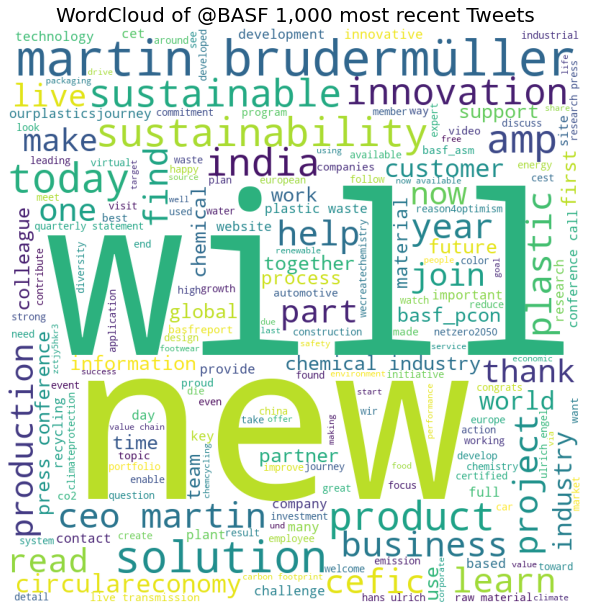

In [73]:
# Create a WordCloud using BASFs' Twitter timeline.  

# Define stopwords; words to exclude from the visualization
stopwords = set(STOPWORDS) | set(["rt","https","http","basf"])
#stopwords.update(["will","new"]) #adding our own stopwords
comment_words = ''

# iterate through the list of tweets
for val in basf_tweets:
      
    # typecaste each val to string
    val = str(val)
  
    # split the value
    tokens = val.split()
      
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
      
    comment_words += " ".join(tokens)+" "

# Create WordCloud object
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10,
                regexp = r"\w{3,}"
                ).generate(comment_words)
  
# plot the WordCloud image                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title("WordCloud of @{} 1,000 most recent Tweets".format(basf_account.data.username),fontdict={"fontsize":20})

plt.show()

## Topic Modeling

In [8]:
# TOPIC MODELLING PACKAGES
! pip install git+https://github.com/bmabey/pyLDAvis/ --upgrade
import pyLDAvis
import pyLDAvis.gensim_models
import gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/bmabey/pyLDAvis/ to /tmp/pip-req-build-vmajblas
  Running command git clone -q https://github.com/bmabey/pyLDAvis/ /tmp/pip-req-build-vmajblas
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done


/usr/local/lib/python3.8/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Iterable
/usr/local/lib/python3.8/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Mapping
/usr/local/lib/python3.8/dist-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [9]:
# Search for, collect, and organize 5,000 tweets
tweet_search = tweepy.Paginator(
        method = client.search_recent_tweets,
        query="basf lang:en -is:retweet", # keyword search
        max_results=100, # number of results per page
        ).flatten(limit=5000) # max number of results to collect

tweets_text = []

for k in tweet_search:
  tweets_text.append(k.data["text"])

In [10]:
# Check how many tweets have been collected
len(tweets_text)

677

In [11]:
# Preview the first 5 tweets
tweets_text[:5]

['@rangecara @GLandsbergis Winner of the politic priviously were BASF etc. The fact that Germany became so dependent on Russian gas is also due to BASF.  The chemical giant has close ties with Gazprom - supported by several federal governments.   Similiar economic situation with Iran.',
 '@VenedigF20 @GLandsbergis In addition:    The fact that Germany became so dependent on Russian gas is also due to BASF.  The chemical giant has close ties with Gazprom - supported by several federal governments.   This an example, one of various only https://t.co/chEyUfHL5Z',
 '@BASF_UK The climate is always changing, it has done so for millions of years. Climate change is entirely down to the activity of the sun. If you, as an arrogant narcissist, think you are in control the weather just leave me out of it.',
 'Truth #6\n\nThere are only the "Big 4" agrochemical and seed firms in the world. Bayer, Corteva, Chem-China, and BASF hold over 60% of the world seed sales. \n\nHoward, H. Philip. (December 1

In [ ]:
# Process all tweets, tokenize, filter, and create an LDA model using the Gensim package.

tweets_tokens = [t.lower().replace("'","").split() for t in tweets_text]
tweets_tokens = [[token for token in tweet if len(token) > 3] for tweet in tweets_tokens]

dictionary = gensim.corpora.Dictionary(tweets_tokens)
dictionary.filter_extremes(no_below=2, no_above=0.5)
corpus = [dictionary.doc2bow(text) for text in tweets_tokens]

lda_model = gensim.models.LdaMulticore(corpus=corpus,
                   id2word=dictionary,
                   num_topics=50, 
                   random_state=0,
                   chunksize=100,
                   per_word_topics=True,)

In [13]:
# Create a dashboard visualization of the LDA model using the pyLDAvis package

vis = pyLDAvis.gensim_models.prepare(
        topic_model = lda_model,
        corpus = corpus,
        dictionary = dictionary
)

pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


## Sentiment Analysis

In [ ]:
#Nicht Fertig

positive = 0
negative = 0
neutral = 0
polarity = 0
tweet_list = []
neutral_list = []
negative_list = []
positive_list = []

for index, row in search_df:
 
 #print(tweet.text)
 tweet_list.append(search_df.text[index])
 analysis = TextBlob(search_df.text[index])
 score = SentimentIntensityAnalyzer().polarity_scores(search_df.text[index])
 neg = score[‘neg’]
 neu = score[‘neu’]
 pos = score[‘pos’]
 comp = score[‘compound’]
 polarity += analysis.sentiment.polarity
 
 if neg > pos:
 negative_list.append(search_df.text[index])
 negative += 1
elif pos > neg:
 positive_list.append(tweet.text)
 positive += 1
 
 elif pos == neg:
 neutral_list.append(tweet.text)
 neutral += 1
positive = percentage(positive, noOfTweet)
negative = percentage(negative, noOfTweet)
neutral = percentage(neutral, noOfTweet)
polarity = percentage(polarity, noOfTweet)
positive = format(positive, ‘.1f’)
negative = format(negative, ‘.1f’)
neutral = format(neutral, ‘.1f’)